In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import scale

In [2]:
from math import log

In [3]:
exclude_sign = "~#$%^&*()[]{}<>|+=1234567890"
replace_sign = "@,.?!-;"

def preprocessing(data):
    ans = []
    for i in range(len(data)):
        sentence = data[i]
        for c in exclude_sign:
            sentence = sentence.replace(c, "")
        for c in replace_sign:
            sentence = sentence.replace(c, " ")
        ans.append(sentence)
    return ans

def plot_contingency_matrix(cm, title, cmap = plt.cm.BuPu):
    plt.figure(figsize=(12,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    x_labels = ["Cluster 1", "Cluster 2"]
    y_labels = ["Class 1", "Class 2"]
    plt.title(title, fontsize = 22)
    plt.colorbar()
    xlocations = np.array(range(len(x_labels)))
    plt.xticks(xlocations, x_labels)
    plt.yticks(xlocations, y_labels)
    tick_array = np.arange(len(x_labels))
    x, y = np.meshgrid(tick_array, tick_array)
    for i, j in zip(x.flatten(), y.flatten()):
        plt.text(j, i, cm[i][j], ha = "center", va = "center", color = "black", fontsize = 24)
    plt.ylabel('Classes', fontsize = 18)
    plt.xlabel('Clusters', fontsize = 18)
    #fig = plt.gcf()
    plt.show()

def plot_result(X, Y_real, Y_clusters, centers, title):
    plt.figure(figsize = (12, 9))
    plt.title(title)
    colors = ["yellow", "green"]
    markers = ['o', 'x']
    for i in range(len(X)):
        if Y_real[i] == 0:
            if Y_clusters[i] == 0:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[0], color = colors[0])
            elif Y_clusters[i] == 1:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[1], color = 'red')
        
        elif Y_real[i] == 1:
            if Y_clusters[i] == 1:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[1], color = colors[1])
            elif Y_clusters[i] == 0:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[0], color = 'blue')
    
    for i in range(2):
        plt.scatter(centers[i, 0], centers[i, 1], marker='+', s=150, linewidths=20, color='black')
    fig = plt.gcf()
    plt.show()
    fig.savefig('visual.png', dpi=300, bbox_inches = 'tight')
    
def perform_kmeans(kmeans, data, Y, method):
    kmeans.fit(data)
    Y_clusters = kmeans.labels_
    centers = kmeans.cluster_centers_
    contingency = contingency_matrix(Y, kmeans.labels_)
    plot_contingency_matrix(contingency, "contingency matrix for " + str(method))
    print('Homogeneity:', metrics.homogeneity_score(Y, kmeans.labels_))
    print('Completeness:', metrics.completeness_score(Y, kmeans.labels_))
    print('V-measure:', metrics.v_measure_score(Y, kmeans.labels_))
    print('Adjusted Rand Score:', metrics.adjusted_rand_score(Y, kmeans.labels_))
    print('Adjusted Mutual Info Score:', metrics.adjusted_mutual_info_score(Y, kmeans.labels_))
    print('')
    plot_result(data, Y, kmeans.labels_, centers, method)

In [4]:
com_class = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_class = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
all_class = com_class + rec_class

all_data = fetch_20newsgroups(subset='all', categories=all_class, shuffle=True, random_state=42)
# 1 represent "recreational activity", 0 represent "computer classes"
Y = [0] * len(all_data.target)
for i in range(len(Y)):
    if all_data.target[i] >= 4:
        Y[i] = 1

trim_all_data = preprocessing(all_data.data)
count_vectorizer = CountVectorizer(min_df=3, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_count = count_vectorizer.fit_transform(trim_all_data)
X_tfidf = tfidf_transformer.fit_transform(X_count)
print (X_tfidf.shape)

(7882, 23825)


In [5]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
X_SVD = svd.fit_transform(X_tfidf)
nmf = NMF(n_components=2, init='random', random_state=0)
X_NMF = nmf.fit_transform(X_tfidf)

X_SVD_norm = scale(X_SVD)
X_NMF_norm = scale(X_NMF)

print(X_SVD.shape)
print(X_NMF.shape)

(7882, 2)
(7882, 2)


In [6]:
def log_transform(X):
    m = X.shape[0]
    n = X.shape[1]
    X_ans = np.zeros((m, n))
    epsilon = 1e-3
    for i in range(m):
        for j in range(n):
            if X[i][j] >= 0:
                X_ans[i][j] = log(X[i][j] + epsilon)
            else:
                X_ans[i][j] = X[i][j]
    return X_ans

In [7]:
kmeans = KMeans(n_clusters=2, max_iter = 1500, n_init = 50, random_state=0)

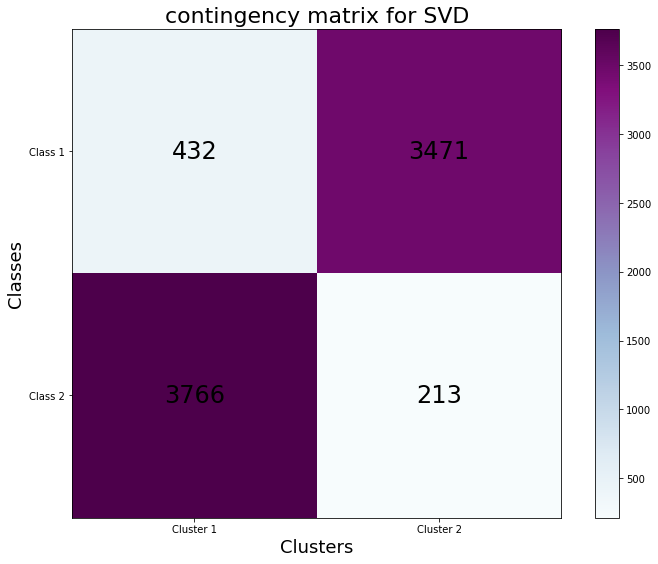

Homogeneity: 0.5963445216111746
Completeness: 0.5981406825121361
V-measure: 0.5972412516079323
Adjusted Rand Score: 0.6994197372158213
Adjusted Mutual Info Score: 0.5972043234414507



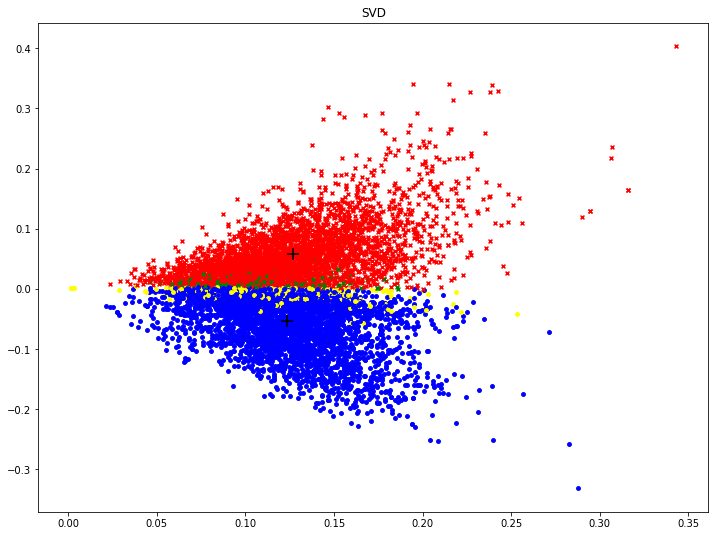

In [8]:
perform_kmeans(kmeans, X_SVD, Y, "SVD")


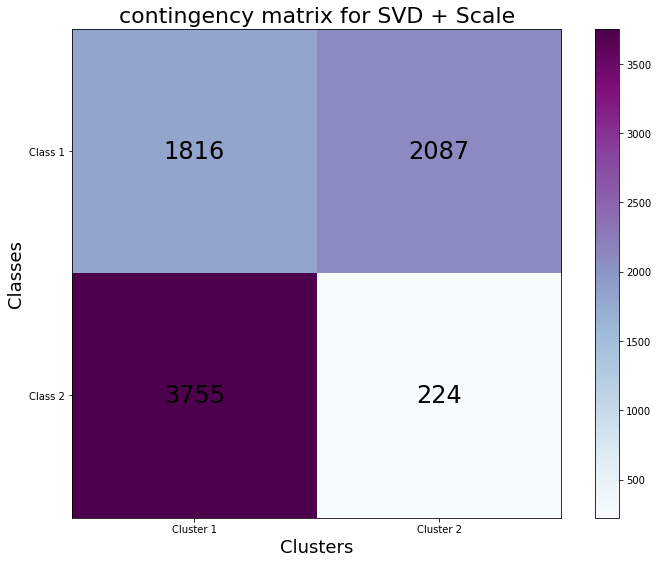

Homogeneity: 0.22159092382780182
Completeness: 0.2538626393883405
V-measure: 0.23663154991165117
Adjusted Rand Score: 0.23258296362008293
Adjusted Mutual Info Score: 0.2365569153445102



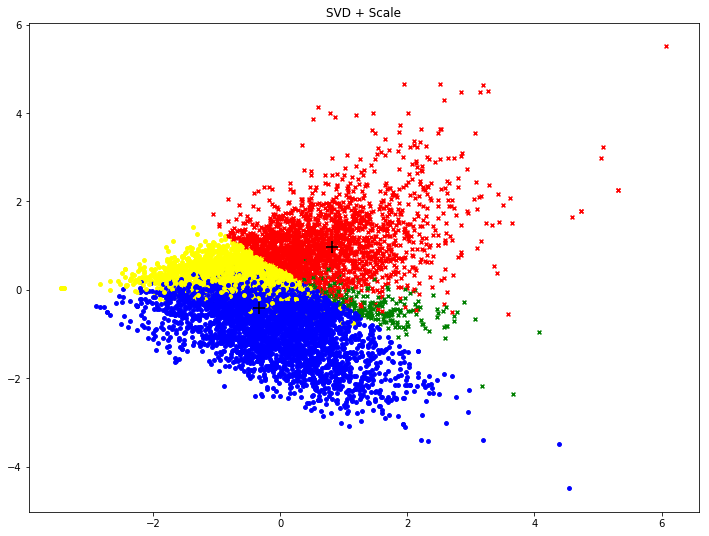

In [24]:
perform_kmeans(kmeans, X_SVD_norm, Y, "SVD + Scale")

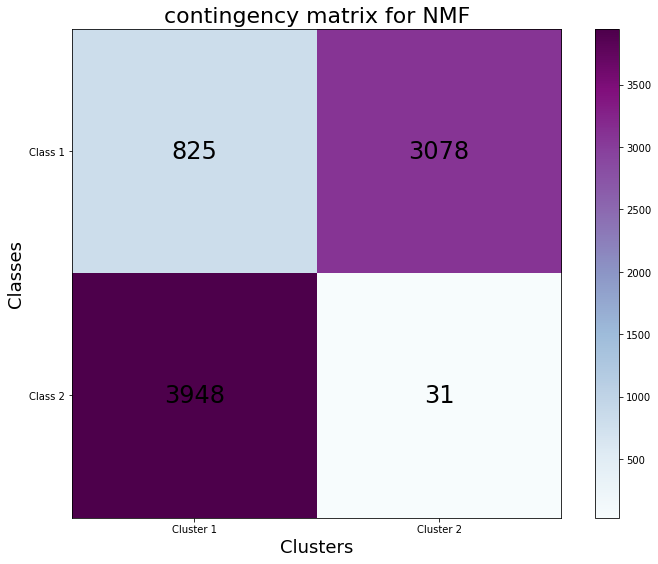

Homogeneity: 0.5659814025415224
Completeness: 0.5848897669067188
V-measure: 0.5752802561988877
Adjusted Rand Score: 0.612721409539299
Adjusted Mutual Info Score: 0.5752407336244971



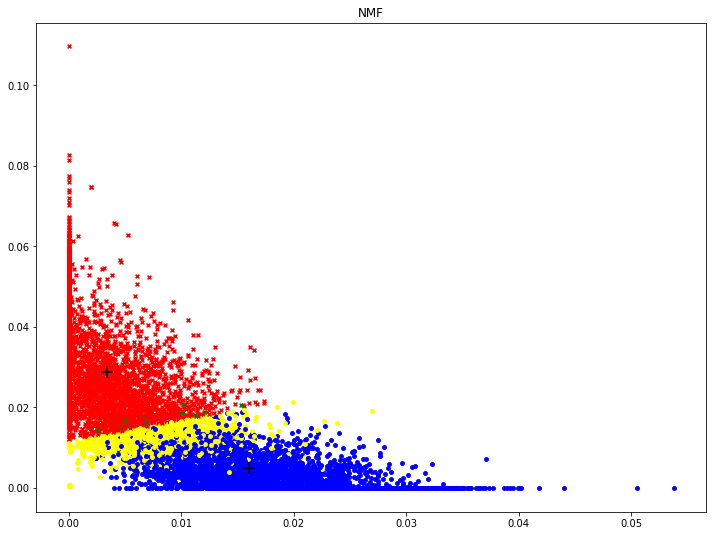

In [10]:
perform_kmeans(kmeans, X_NMF, Y, "NMF")

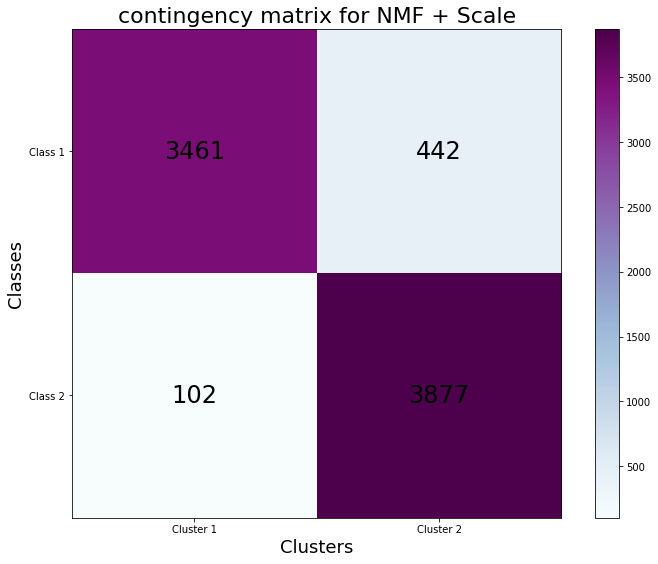

Homogeneity: 0.6542084244239099
Completeness: 0.6585414449475612
V-measure: 0.6563677836407055
Adjusted Rand Score: 0.7429493497582114
Adjusted Mutual Info Score: 0.6563362200922802



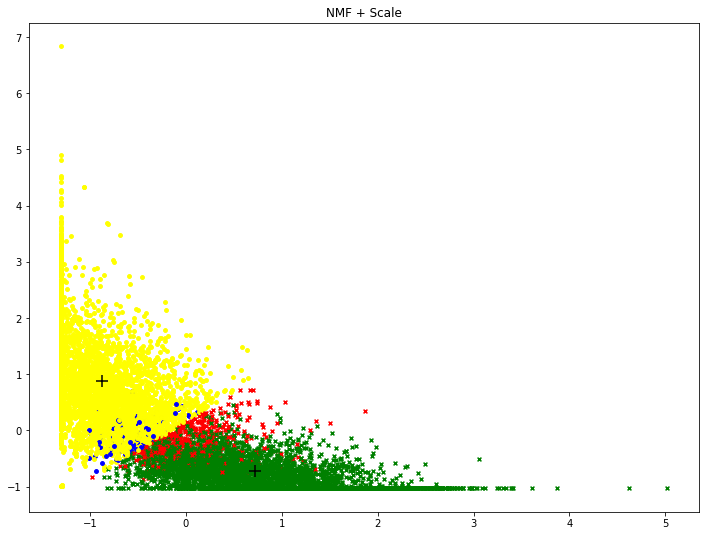

In [25]:
perform_kmeans(kmeans, X_NMF_norm, Y, "NMF + Scale")

In [9]:
X_NMF_nonlinear = log_transform(X_NMF)

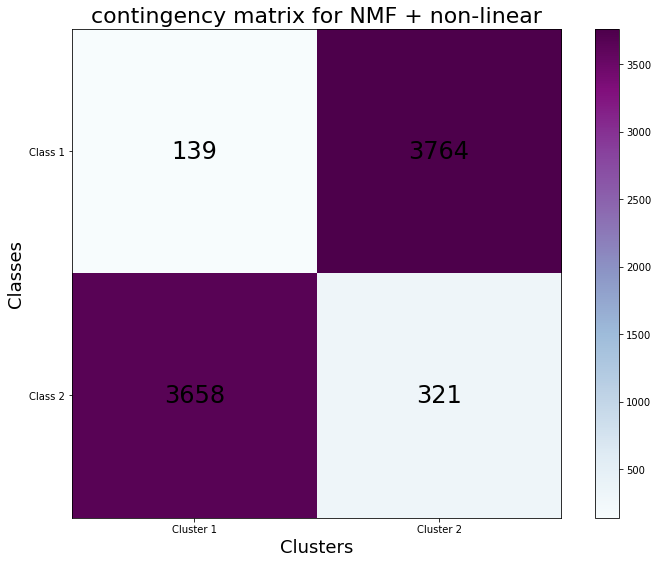

Homogeneity: 0.6850246331356349
Completeness: 0.6856391546262102
V-measure: 0.6853317561240686
Adjusted Rand Score: 0.7801527704217779
Adjusted Mutual Info Score: 0.6853029352320914



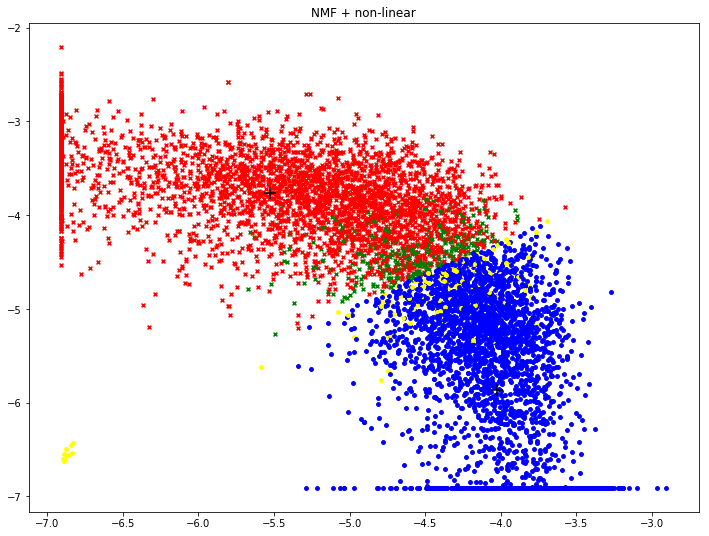

In [27]:
perform_kmeans(kmeans, X_NMF_nonlinear, Y, "NMF + non-linear")

In [20]:
print(X_NMF_norm)

[[-0.21479889  0.24727015]
 [-1.06169347  0.84797723]
 [-1.30030787  2.12380812]
 ...
 [-0.555434    0.04232878]
 [ 0.15673316  0.16715701]
 [-0.27214303 -0.47506093]]


In [10]:
X_NMF_nonlinear_norm = log_transform(X_NMF_norm)

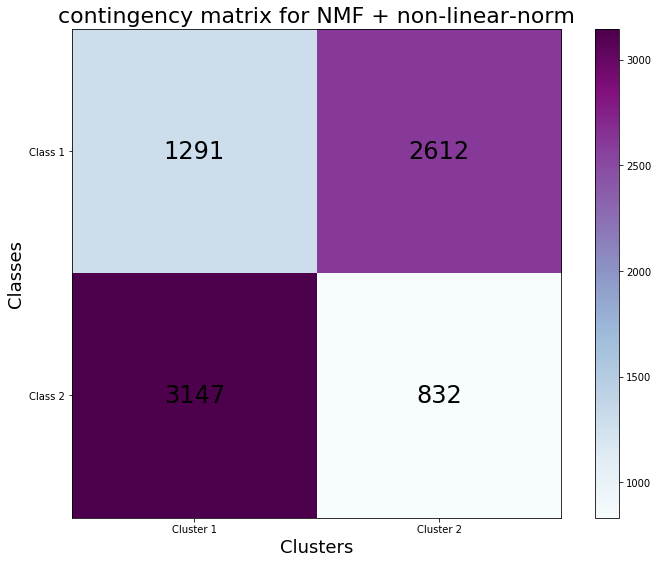

Homogeneity: 0.16162292247194399
Completeness: 0.16349269760513585
V-measure: 0.1625524333989188
Adjusted Rand Score: 0.212702135108898
Adjusted Mutual Info Score: 0.16247532355491068



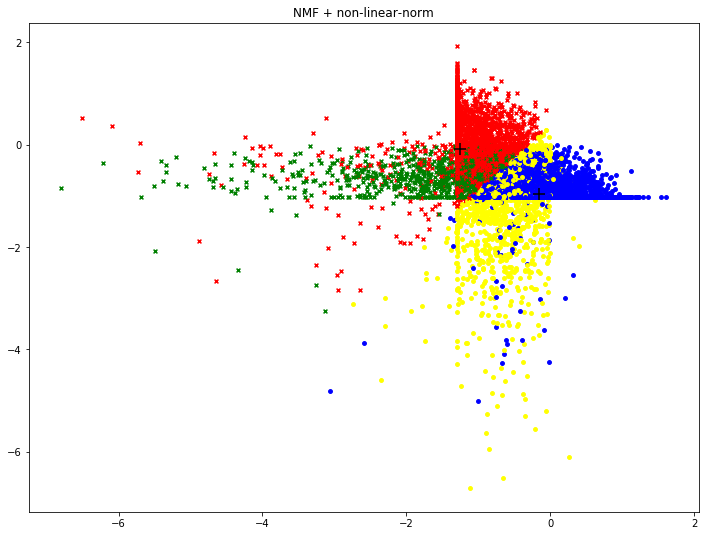

In [11]:
perform_kmeans(kmeans, X_NMF_nonlinear_norm, Y, "NMF + non-linear-norm")